## Homework 4



In [49]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("default")

%matplotlib inline

Data:

- https://github.com/gastonstat/CreditScoring
- Also available [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv)

In [3]:
!curl https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv --output CreditScoring.csv


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  178k  100  178k    0     0   341k      0 --:--:-- --:--:-- --:--:--  342k


## Preparation 

We'll talk about this dataset in more details in week 6. But for now, use the following code to get started

In [4]:
df = pd.read_csv('CreditScoring.csv')
df.columns = df.columns.str.lower()

Some of the features are encoded as numbers. Use the following code to de-code them:

In [5]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

Prepare the numerical variables:

In [6]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status

In [7]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [8]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

## Your code

What are the categorical variables? What are the numerical?

In [26]:
df.head(10)

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price,default
0,9,rent,60,30,married,no,freelance,73,129,0,0,800,846,0
1,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658,0
2,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985,1
3,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325,0
4,0,rent,36,26,single,no,fixed,46,107,0,0,310,910,0
5,1,owner,60,36,married,no,fixed,75,214,3500,0,650,1645,0
6,29,owner,60,44,married,no,fixed,75,125,10000,0,1600,1800,0
7,9,parents,12,27,single,no,fixed,35,80,0,0,200,1093,0
8,0,owner,60,32,married,no,freelance,90,107,15000,0,1200,1957,0
9,0,parents,48,41,married,no,partime,90,80,0,0,1200,1468,1


In [14]:
categorical = ["home",  "marital",  "records","job"]
numerical = ["seniority", "time", "age", "expenses", "income", "assets", "debt", "amount", "price"]
assert df.shape[1] == len(categorical+numerical) +1

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`

In [23]:
RANDOM_STATE = 1

from sklearn.model_selection import train_test_split

train_validation_df , test_df = train_test_split(df, 
                                                 test_size=0.4, train_size = 0.6, random_state=RANDOM_STATE)
train_df , validation_df = train_test_split(train_validation_df, 
                                            test_size= 0.25, train_size=0.75, random_state=RANDOM_STATE)

In [24]:
y_train = train_df["default"]
del train_df["default"]
X_train = train_df

y_val = validation_df["default"]
del validation_df["default"]
X_val = validation_df

y_test = test_df["default"]
del test_df["default"]
X_test = test_df

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the default variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [55]:
from sklearn.metrics import roc_auc_score

In [71]:
max_auc = 0
max_auc_var=None
for numvar in numerical: 
    _auc_df  = pd.concat([train_df[numvar], y_train], axis=1)
    _auc_df = _auc_df[[numvar, "default"]].sort_values(by=numvar)
    
    _auc = roc_auc_score( _auc_df["default"] , _auc_df[numvar] , multi_class="ovo")
    if _auc < 0.5:
        _auc = roc_auc_score( _auc_df["default"] , -_auc_df[numvar] , multi_class="ovo")
    print(f"AUC for {numvar} is : {_auc}")
    if numvar in ["seniority", "time", "income", "debt"] and _auc>max_auc:
        max_auc = _auc
        max_auc_var = numvar
        
max_auc_var, max_auc

AUC for seniority is : 0.7017118944012192
AUC for time is : 0.5506261530440362
AUC for age is : 0.5766648953236544
AUC for expenses is : 0.510421888786396
AUC for income is : 0.6837688998957246
AUC for assets is : 0.6303848409801877
AUC for debt is : 0.5013065743563007
AUC for amount is : 0.5831915005614823
AUC for price is : 0.5228659912168123


('seniority', 0.7017118944012192)

Which categorical variable (among the following 4) has the highest AUC?

- seniority
- time
- income
- debt

## Training the model

From now on, use these columns only:

```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [54]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
train_cols = ['seniority', 'income', 'assets', 'records', 'job', 'home']

In [46]:
dv = DictVectorizer(sparse=False)
train_dict = X_train[train_cols].to_dict(orient="records")

X_train = dv.fit_transform(train_dict)

val_dict = X_val[train_cols].to_dict(orient="records")
X_val = dv.transform(val_dict)

In [47]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [50]:
model.fit(X_train,y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [51]:
y_pred = model.predict_proba(X_val)[:,1]

In [53]:
roc_auc_score(y_val, y_pred)

0.8147457779374776

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- 0.812

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

In [122]:
scores = list()

thresholds = np.arange(0,1.01,0.01)

for thrsld in thresholds:

    tp = ((y_pred >= thrsld) & (y_val == 1)).sum()
    fp = ((y_pred >= thrsld) & (y_val == 0)).sum()
    fn = ((y_pred < thrsld) & (y_val == 1)).sum()
    tn = ((y_pred < thrsld) & (y_val == 0)).sum()
 
    precision = round(tp / (tp+fp),4) if tp>0 and fp>0 else 1
    recall = round(tp / (tp+fn),4)
    
    scores.append((thrsld, tp, fp, fn, tn , precision, recall))

In [123]:
df_scores = pd.DataFrame(scores)
df_scores.columns= ["threshold", "tp", "fp", "fn", "tn", "precision", "recall"]

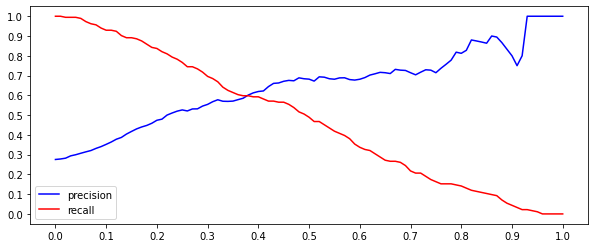

In [124]:
plt.figure(figsize=(10, 4))

plt.plot(df_scores.threshold, df_scores.precision, color='blue', linestyle='solid', label='precision')
plt.plot(df_scores.threshold, df_scores.recall, color='red', linestyle='solid', label='recall')
plt.legend()

plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.show()

In [128]:
df_scores.loc[(df_scores.threshold>0.35) & (df_scores.threshold < 0.45)]

,threshold,tp,fp,fn,tn,precision,recall
35,0.35,113,85,71,399,0.5707,0.6141
36,0.36,111,81,73,403,0.5781,0.6033
37,0.37,110,78,74,406,0.5851,0.5978
38,0.38,110,73,74,411,0.6011,0.5978
39,0.39,109,69,75,415,0.6124,0.5924
40,0.40,109,67,75,417,0.6193,0.5924
41,0.41,107,65,77,419,0.6221,0.5815
42,0.42,105,58,79,426,0.6442,0.5707
43,0.43,105,54,79,430,0.6604,0.5707
44,0.44,104,53,80,431,0.6624,0.5652


At which threshold precision and recall curves intersect?

* 0.2
* 0.4
* 0.6
* 0.8

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [129]:
df_scores["f1"] = (2 * df_scores.precision*df_scores.recall) / (df_scores.precision+df_scores.recall)

In [131]:
df_scores.sort_values(by="f1", ascending=False).head(8)

,threshold,tp,fp,fn,tn,precision,recall,f1
24,0.24,144,133,40,351,0.5199,0.7826,0.624758
25,0.25,141,127,43,357,0.5261,0.7663,0.623879
23,0.23,146,140,38,344,0.5105,0.7935,0.621291
31,0.31,126,96,58,388,0.5676,0.6848,0.620716
27,0.27,137,121,47,363,0.5310,0.7446,0.619916
29,0.29,132,110,52,374,0.5455,0.7174,0.619751
32,0.32,123,90,61,394,0.5775,0.6685,0.619677
22,0.22,149,149,35,335,0.5000,0.8098,0.618262


At which threshold F1 is maximal?

- 0.1
- 0.3
- 0.5
- 0.7

## Question 5


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


In [147]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression


In [150]:
N_SPLITS = 5
kfold = KFold(n_splits=N_SPLITS, shuffle=True, random_state=1)

In [151]:
def train(df, y):
    
    dv = DictVectorizer(sparse=False)
    train_dict = df.to_dict(orient="records")
    X_train = dv.fit_transform(train_dict)
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y)
    
    return dv, model

def validate(df,dv, model):
    
    val_dicts = df.to_dict(orient="records")
    X_val = dv.transform(val_dicts)
    y_pred = model.predict_proba(X_val)[:,1]
    return y_pred
    

In [152]:
# my "df_train_full" was train_validation_df
scores = list()
for train_idx, val_idx in kfold.split(train_validation_df):
    
    train_df = train_validation_df[train_cols].iloc[train_idx]
    y_train  = train_validation_df["default"].iloc[train_idx]
    
    val_df = train_validation_df[train_cols].iloc[val_idx]
    y_val = train_validation_df["default"].iloc[val_idx]
    
    _dv, _model = train(train_df, y_train)
    
    y_pred  = validate(val_df, _dv, _model)
    
    _auc = roc_auc_score(y_val, y_pred)
    
    scores.append(_auc)
    print(f"ROC AUC for this iteration: {_auc}")  

ROC AUC for this iteration: 0.8101383949008698
ROC AUC for this iteration: 0.7905151161281952
ROC AUC for this iteration: 0.8387909544159544
ROC AUC for this iteration: 0.8318968672229542
ROC AUC for this iteration: 0.8167214750221697


In [153]:
np.std(scores)

0.016991141595724745

How large is standard devidation of the scores across different folds?

- 0.001
- 0.014
- 0.09
- 0.14

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std

In [158]:
def train_with_c(df, y, C):
    
    dv = DictVectorizer(sparse=False)
    train_dict = df.to_dict(orient="records")
    X = dv.fit_transform(train_dict) 
    
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X, y)
    
    return dv, model

In [168]:
for c in [0.01, 0.1, 1, 10]:
    
    scores=list()
    for tr_idx, val_idx in kfold.split(train_validation_df):
        
        df_tr = train_validation_df[train_cols].iloc[tr_idx]
        y_tr = train_validation_df.default.iloc[tr_idx]
        
        _dv, _model  = train_with_c(df_tr, y_tr, C=c)
        
        df_val = train_validation_df[train_cols].iloc[val_idx]
        y_val = train_validation_df.default.iloc[val_idx]
        
        y_pred = validate(df_val,_dv, _model)
        
        _auc = roc_auc_score(y_val, y_pred)
        
        #print(f"\t\tC: {c} AUC {_auc}")
        scores.append(_auc)
    _mean = round(np.mean(scores),3)
    _std = round(np.std(scores),3)
    print(f"summary for c={c}: mean: {_mean} std:{_std}")

summary for c=0.01: mean: 0.807 std:0.015
summary for c=0.1: mean: 0.818 std:0.016
summary for c=1: mean: 0.818 std:0.017
summary for c=10: mean: 0.818 std:0.017


Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

## Submit the results

Submit your results here: https://forms.gle/e497sR5iB36mM9Cs5

It's possible that your answers won't match exactly. If it's the case, select the closest one.

## Deadline

The deadline for submitting is 04 October 2021, 17:00 CET. After that, the form will be closed.